In [1]:
import itertools
import pandas as pd
import numpy as np
from slugify import slugify

# Google Cloud Platform API
from google.cloud import bigquery
from google.cloud import storage
from google.oauth2 import service_account
import dask.dataframe as dd
import gcsfs

# GIS-Spatial Analysis Libraries
import geopandas as gpd
from geopandas import GeoSeries

from shapely.geometry import Point, Polygon, MultiPolygon
from shapely.ops import cascaded_union, unary_union
from shapely import wkt
from shapely.wkt import loads

import seaborn as sns

import geopy
from geopy import distance

import pysal as ps

import fiona
from fiona.crs import from_epsg

from descartes import PolygonPatch

#Plots and Graphs
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
from matplotlib.colors import ListedColormap
import seaborn as sb

# System Libraries
import os
import sys
import time
from timeit import default_timer as timer
import shutil
from shutil import make_archive, rmtree

import csv
import os.path
from os import path

# Timestamp
from datetime import datetime  
from datetime import timedelta  

# Parsers
# NOTE: https://www.youtube.com/watch?v=aghhs33gi-g
from configparser import ConfigParser
import configargparse

#Nearest Neighbor
import libpysal

#Math Funstions
from math import radians, cos, sin, asin, sqrt, exp

#Load Model
import pickle


#Data Format
import json

#AI/ML
import spint
from spint.gravity import  BaseGravity, Gravity, Production, Attraction, Doubly
from spint.dispersion import phi_disp
from spint.vec_SA import VecMoran


#Panda Settings
pd.set_option('display.max_columns', 500)

parser = ConfigParser()
parser.read('C:/Users/a110463/OneDrive - Aspen Dental Management Inc/Documents/aspenconfig.ini')


databaseCredentialsKey = parser.get('DatabaseCredentials','CredentialKey')
databasetableTraffic = parser.get('DatabaseTables','DatabaseName')+"."+parser.get('DatabaseTables','DatasetName')+"."+parser.get('DatabaseTables','TableScenarioTrafficFinal')
databasetableCBG = parser.get('DatabaseTables','DatabaseName')+"."+parser.get('DatabaseTables','DatasetName')+"."+parser.get('DatabaseTables','TableCBG')
databasetableDemand = parser.get('DatabaseTables','DatabaseName')+"."+parser.get('DatabaseTables','DatasetName')+"."+parser.get('DatabaseTables','TableScenarioTrafficDemand')


os.environ['GOOGLE_APPLICATION_CREDENTIALS'] = databaseCredentialsKey
credentials = service_account.Credentials.from_service_account_file(databaseCredentialsKey)
client = bigquery.Client(credentials = credentials)

storage_client = storage.Client.from_service_account_json(databaseCredentialsKey)
storage_client = storage.Client()

bucket_name = 'aspen-model'
bucket = storage_client.get_bucket(bucket_name)


C:\Users\a110463\Anaconda3\envs\Aspen\lib\site-packages\pysal\explore\segregation\network\network.py:15: UserWarning: You need pandana and urbanaccess to work with segregation's network module
You can install them with  `pip install urbanaccess pandana` or `conda install -c udst pandana urbanaccess`
  warn(
C:\Users\a110463\Anaconda3\envs\Aspen\lib\site-packages\pysal\model\spvcm\abstracts.py:10: UserWarning: The `dill` module is required to use the sqlite backend fully.
  from .sqlite import head_to_sql, start_sql


In [6]:



#Write Query on BQ
QUERY = """
SELECT *
FROM
  `admi-realestate-prod.sti_popstats_raw.mosPOPB`
LIMIT 100;
  """
#Run the query and write result to a pandas data frame
Query_Results = client.query(QUERY)
df = Query_Results.to_dataframe()
#View top few rows of result
df.head()

,state,county,tract,bg,POP,MOSUSPOPA01,MOSUSPOPA02,MOSUSPOPA03,MOSUSPOPA04,MOSUSPOPA05,MOSUSPOPA06,MOSUSPOPB07,MOSUSPOPB08,MOSUSPOPB09,MOSUSPOPB10,MOSUSPOPC11,MOSUSPOPC12,MOSUSPOPC13,MOSUSPOPC14,MOSUSPOPD15,MOSUSPOPD16,MOSUSPOPD17,MOSUSPOPD18,MOSUSPOPE19,MOSUSPOPE20,MOSUSPOPE21,MOSUSPOPF22,MOSUSPOPF23,MOSUSPOPG24,MOSUSPOPG25,MOSUSPOPH26,MOSUSPOPH27,MOSUSPOPH28,MOSUSPOPH29,MOSUSPOPI30,MOSUSPOPI31,MOSUSPOPI32,MOSUSPOPI33,MOSUSPOPJ34,MOSUSPOPJ35,MOSUSPOPJ36,MOSUSPOPK37,MOSUSPOPK38,MOSUSPOPK39,MOSUSPOPK40,MOSUSPOPL41,MOSUSPOPL42,MOSUSPOPL43,MOSUSPOPM44,MOSUSPOPM45,MOSUSPOPN46,MOSUSPOPN47,MOSUSPOPN48,MOSUSPOPN49,MOSUSPOPO50,MOSUSPOPO51,MOSUSPOPO52,MOSUSPOPO53,MOSUSPOPO54,MOSUSPOPO55,MOSUSPOPP56,MOSUSPOPP57,MOSUSPOPP58,MOSUSPOPP59,MOSUSPOPP60,MOSUSPOPP61,MOSUSPOPQ62,MOSUSPOPQ63,MOSUSPOPQ64,MOSUSPOPQ65,MOSUSPOPR66,MOSUSPOPR67,MOSUSPOPS68,MOSUSPOPS69,MOSUSPOPS70,MOSUSPOPS71,MOSUSPOPU99,MUS_PGA,MUS_PGB,MUS_PGC,MUS_PGD,MUS_PGE,MUS_PGF,MUS_PGG,MUS_PGH,MUS_PGI,MUS_PGJ,MUS_PGK,MUS_PGL,MUS_PGM,MUS_PGN,MUS_PGO,MUS_PGP,MUS_PGQ,MUS_PGR,MUS_PGS,MUS_PGU,_10blockgroup
0,1,1031,1031011202,10310112022,3476,0,0,0,3,0,0,0,4,156,0,10,0,0,6,0,0,0,92,0,199,0,26,156,85,0,0,0,72,11,0,42,0,0,44,0,17,4,0,0,40,0,268,0,17,47,0,1,116,0,97,1086,42,6,322,233,60,0,0,3,0,1,0,0,112,59,29,0,4,3,0,3,0,3,160,16,92,199,182,85,83,42,61,44,268,64,117,1786,64,171,29,10,0,NaN
1,1,1051,1051031300,10510313001,1958,0,37,0,34,15,2,0,8,52,0,0,0,0,0,0,0,0,18,3,14,43,9,23,12,0,0,0,0,5,0,32,0,0,0,0,70,6,5,3,185,0,66,17,35,50,0,3,500,0,73,151,105,0,105,119,14,0,0,8,0,0,2,0,82,23,21,0,0,8,0,0,0,88,60,0,18,60,32,12,5,32,70,199,83,85,503,553,22,107,21,8,0,NaN
2,1,1073,1073002400,10730024003,606,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,37,0,0,0,0,16,24,0,0,0,0,0,0,0,0,0,0,0,0,4,0,0,4,0,7,0,0,4,3,0,81,0,0,15,102,0,22,4,9,3,0,0,0,0,0,0,43,3,15,52,0,73,0,85,0,0,0,0,37,0,16,24,0,0,0,8,7,4,84,143,12,46,67,158,0,NaN
3,1,1073,1073004902,10730049022,1196,0,2,0,0,0,0,0,0,56,2,3,0,0,0,0,0,0,13,92,10,0,35,0,69,20,0,0,0,0,0,0,0,0,6,0,0,0,12,13,128,0,48,0,0,15,0,0,0,0,3,63,93,88,207,63,1,23,7,0,2,0,8,0,23,8,35,0,0,10,0,38,0,2,58,3,13,102,35,89,0,0,6,153,48,15,0,517,33,39,35,48,0,NaN
4,1,1073,1073004902,10730049023,650,0,0,3,0,5,0,0,0,16,0,12,0,0,0,0,0,0,10,39,0,0,14,0,44,10,0,0,0,0,0,0,0,0,2,0,0,0,0,3,30,0,0,0,0,0,0,0,7,0,7,10,135,28,170,28,2,13,0,0,2,1,1,0,1,5,21,0,0,15,0,16,0,8,16,12,10,39,14,54,0,0,2,33,0,0,7,378,18,7,21,31,0,NaN


In [86]:
analogs = "C:/Users/a110463/OneDrive - Aspen Dental Management Inc/Documents/AspenAnalogs.csv"
df=pd.read_csv(analogs)

In [87]:
df=df.fillna(0)
df.head()

,Facility Code,Facility Name,DMA,DMA Code,State,Ownership (POP/LGP),Owner (POP Name),De Novo Class (Year),Pop. (3 Mile),Density Class,Total Population,Median Age,Median HH Income,"% HH w/ Income $200,000+",Median Housing Value,% White,% Black,% Hispanic Origin,% Speaking Only Eng,% HS Ed. or less,% Blue Collar,% Veterans,% No Health Insurance,% Medicaid,Delta Dental (per 10K Pop),Aspen Dental (10 mi),Aspen Dental (10-20 mi),2018 - 2020 Average Revenue,TTM Revenue,2018 - 2020 Average NPD,TTM NPD,2018 - 2020 Average DTFA,TTM DTFA
0,1009.0,"Plainfield, IN","Indianapolis, IN",539.0,IN,LGP,0,2008,40547.0,Suburban,256110.0,38.1,67306.0,0.0367,196711.0,0.8820,0.0573,0.0534,0.9250,0.4483,0.4419,0.0819,0.0780,0.1452,0.0000,1.0,4.0,1254313.28,1467831.5,4.78,4.6,3.71,3.4
1,1016.0,"Brooksville, FL","Tampa et al, FL",682.0,FL,POP,ANDREW LEE,2009,34864.0,Suburban,203695.0,50.4,50419.0,0.0177,295206.0,0.8943,0.0465,0.1099,0.8946,0.4680,0.4219,0.1324,0.1163,0.1958,0.0000,1.0,0.0,1727447.98,2217388.3,6.67,5.9,4.66,4.8
2,1019.0,"West Burlington, IA","Davenport et al, IA-IL",820.0,IA,LGP,0,2009,14620.0,Most Rural,106600.0,43.0,53631.0,0.0232,116182.0,0.9270,0.0331,0.0323,0.9666,0.4465,0.5211,0.0958,0.0401,0.2016,0.0000,0.0,0.0,1289064.59,1302882.4,5.13,4,4.3,5.3
3,1029.0,"Keizer, OR","Portland, OR",508.0,OR,POP,LIVINGSTON,2009,76755.0,Suburban,401844.0,37.5,62673.0,0.0378,372201.0,0.8133,0.0093,0.2277,0.7694,0.3918,0.4552,0.0801,0.0734,0.2448,1.8664,0.0,1.0,1383228.56,1838802,5.03,4.3,4.22,4.3
4,103.0,"Belle Vernon, PA","Pittsburgh, PA",527.0,PA,LGP,0,2006,24056.0,Rural,104450.0,45.2,57021.0,0.0293,132679.0,0.9403,0.0331,0.0137,0.9765,0.5029,0.4760,0.0923,0.0399,0.1818,1.3404,0.0,4.0,503610.77,754869.9,2.22,2.8,3.13,7.7


<IPython.core.display.Javascript object>


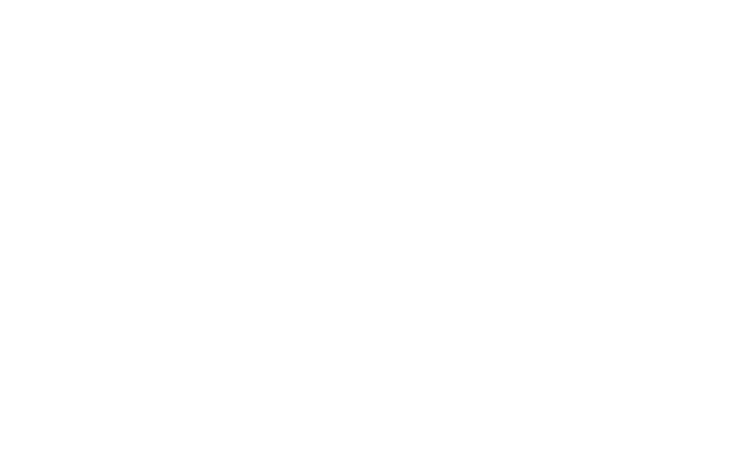

In [88]:
##Plot Revenue Frequency
plt.figure(figsize=(10,6))
plt.title("Age Frequency")
sns.axes_style("dark")
sns.violinplot(y=df["Median Age"])
plt.show()

<IPython.core.display.Javascript object>


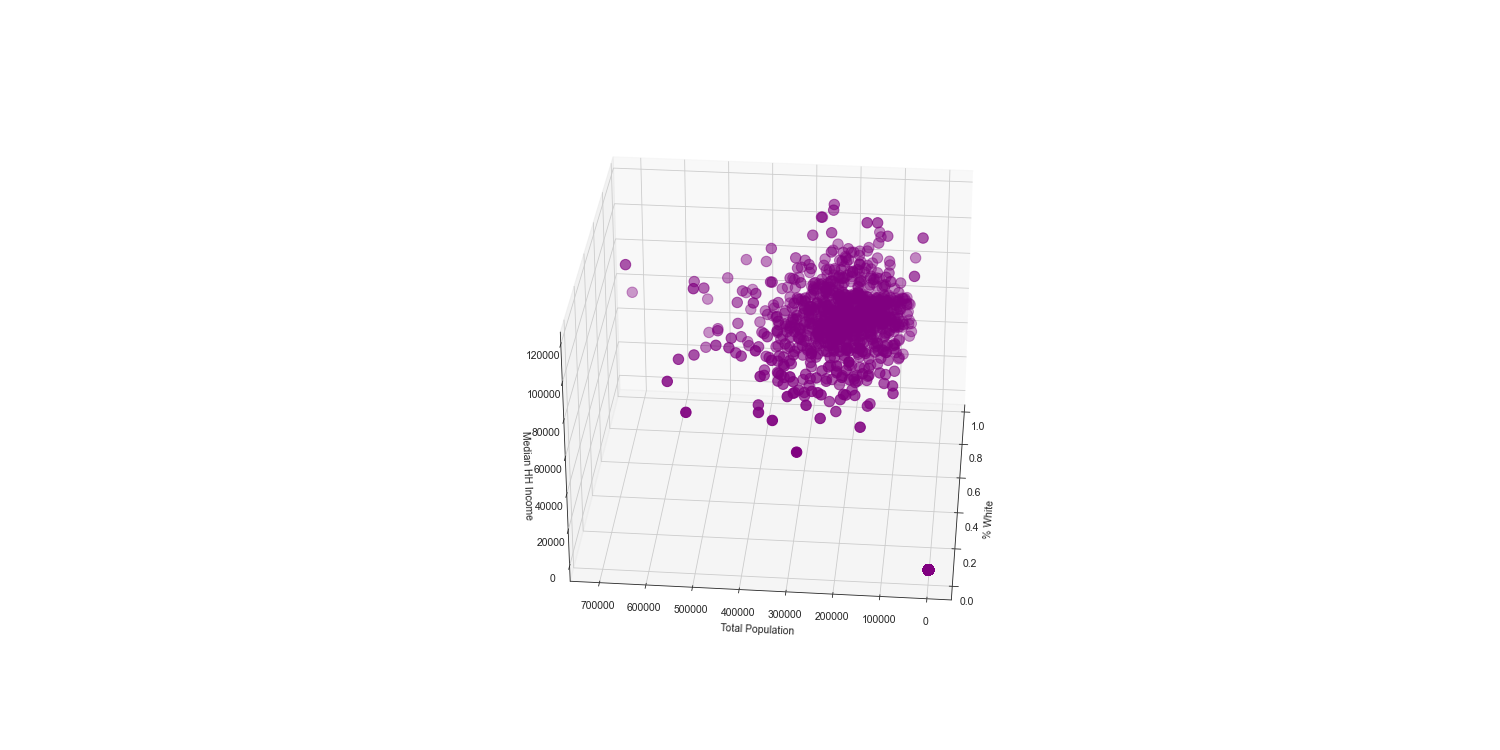

In [89]:
%matplotlib notebook

from mpl_toolkits.mplot3d import Axes3D

sns.set_style("white")
fig = plt.figure(figsize=(20,10))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(df["% White"], df["Total Population"], df["Median HH Income"], c='purple', s=100)
ax.view_init(30, 185)
plt.xlabel("% White")
plt.ylabel("Total Population")
ax.set_zlabel('Median HH Income')
plt.show()

In [91]:
sub_df= df[["Median HH Income", "% White"]]
#sub_df=sub_df[sub_df["Median Age"] > 5]



In [73]:
sub_df = sub_df[['Median HH Income', '% White']]

sub_df = sub_df[sub_df["% White"]>.1]
sub_df = sub_df.sample(n=75)

<IPython.core.display.Javascript object>


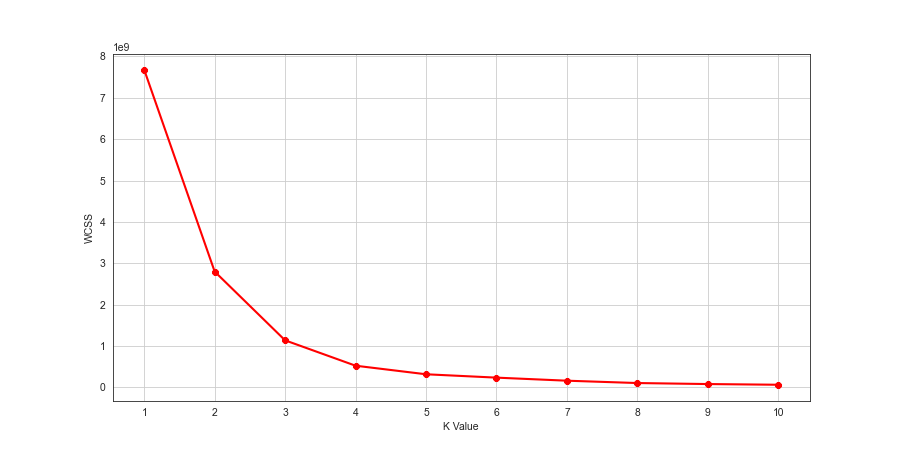

In [74]:

from sklearn.cluster import KMeans
wcss = []
for k in range(1,11):
    kmeans = KMeans(n_clusters=k, init="k-means++")
    kmeans.fit(sub_df)
    wcss.append(kmeans.inertia_)
plt.figure(figsize=(12,6))    
plt.grid()
plt.plot(range(1,11),wcss, linewidth=2, color="red", marker ="8")
plt.xlabel("K Value")
plt.xticks(np.arange(1,11,1))
plt.ylabel("WCSS")
plt.show()


In [75]:
#competition counts in Trade Area
#trade area overlaps
#Key demos
#insurance rates
#Anal

In [76]:
from kneed import KneeLocator

max_k = 10
kl = KneeLocator(range(1, max_k+1), wcss, curve='convex', direction = "decreasing")
optimum_k = kl.elbow

In [77]:
optimum_k

3

<IPython.core.display.Javascript object>


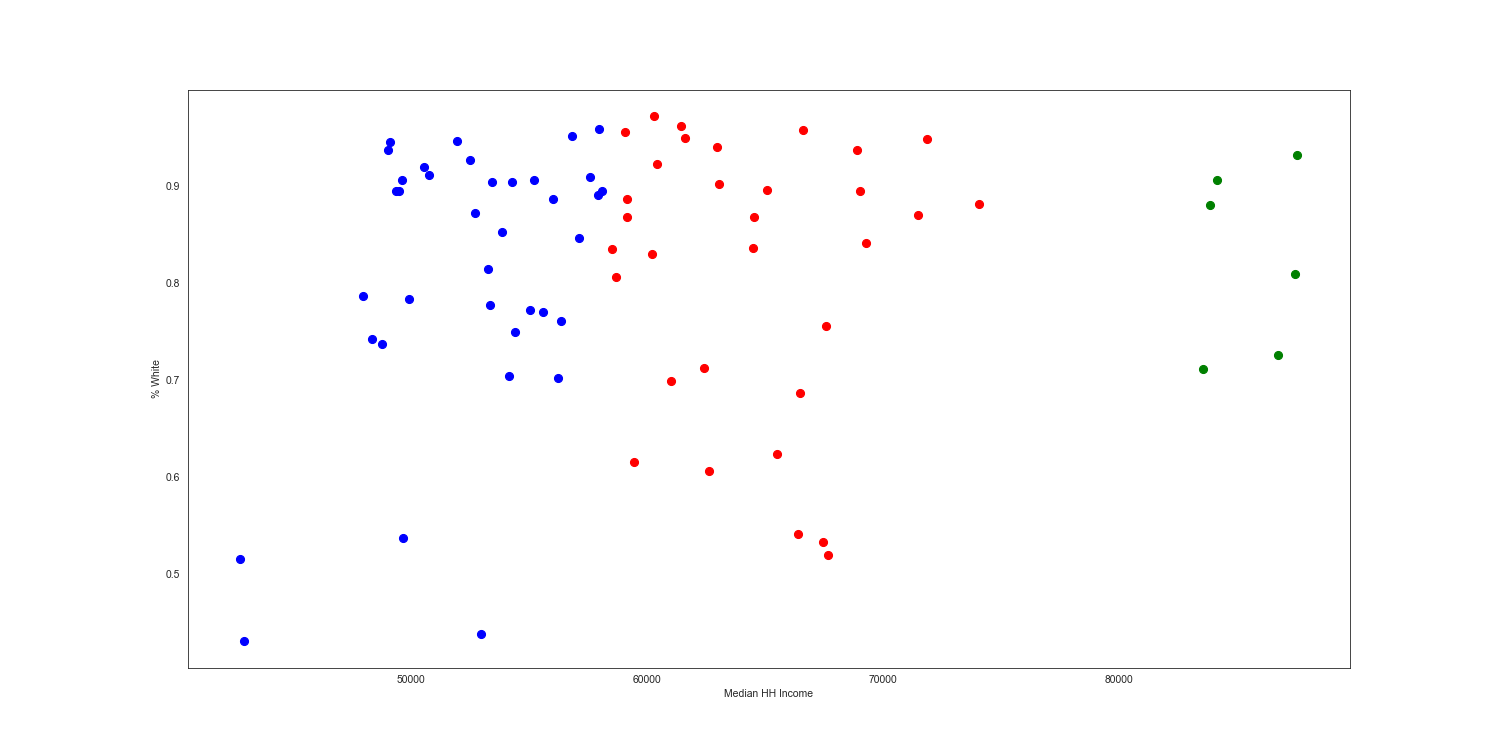

In [78]:
km = KMeans(n_clusters=3)
clusters = km.fit_predict(sub_df)
sub_df["label"] = clusters
centroids  = km.cluster_centers_  #means of shape [10,] 
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
 
fig = plt.figure(figsize=(20,10))
ax = fig.add_subplot(111, ) #projection='3d')
ax.scatter(sub_df["Median HH Income"][sub_df.label == 0], sub_df["% White"][sub_df.label == 0], c='blue', s=60)
ax.scatter(sub_df["Median HH Income"][sub_df.label == 1], sub_df["% White"][sub_df.label == 1], c='red', s=60)
ax.scatter(sub_df["Median HH Income"][sub_df.label == 2], sub_df["% White"][sub_df.label == 2], c='green', s=60)
ax.scatter(sub_df["Median HH Income"][sub_df.label == 3], sub_df["% White"][sub_df.label == 3], c='purple', s=60)

#ax.view_init(30, 185)
plt.xlabel("Median HH Income")
plt.ylabel("% White")
plt.show()

In [79]:
centroid_labels = [centroids[i] for i in clusters]

In [80]:
centroid_labels

[array([5.25546216e+04, 8.13297297e-01]),
 array([6.4251750e+04, 8.1454375e-01]),
 array([5.25546216e+04, 8.13297297e-01]),
 array([5.25546216e+04, 8.13297297e-01]),
 array([6.4251750e+04, 8.1454375e-01]),
 array([5.25546216e+04, 8.13297297e-01]),
 array([5.25546216e+04, 8.13297297e-01]),
 array([5.25546216e+04, 8.13297297e-01]),
 array([5.25546216e+04, 8.13297297e-01]),
 array([5.25546216e+04, 8.13297297e-01]),
 array([8.55406667e+04, 8.27733333e-01]),
 array([5.25546216e+04, 8.13297297e-01]),
 array([5.25546216e+04, 8.13297297e-01]),
 array([6.4251750e+04, 8.1454375e-01]),
 array([5.25546216e+04, 8.13297297e-01]),
 array([6.4251750e+04, 8.1454375e-01]),
 array([5.25546216e+04, 8.13297297e-01]),
 array([5.25546216e+04, 8.13297297e-01]),
 array([5.25546216e+04, 8.13297297e-01]),
 array([6.4251750e+04, 8.1454375e-01]),
 array([5.25546216e+04, 8.13297297e-01]),
 array([6.4251750e+04, 8.1454375e-01]),
 array([5.25546216e+04, 8.13297297e-01]),
 array([6.4251750e+04, 8.1454375e-01]),
 array

In [82]:
#data from scenario
scenario = np.array([400000,225000])
diff = centroid_labels-scenario
dist= np.sqrt(np.sum(diff**2, axis=-1))

print(dist)



[413935.89476315 404167.68900302 413935.89476315 413935.89476315
 404167.68900302 413935.89476315 413935.89476315 413935.89476315
 413935.89476315 413935.89476315 386664.32450011 413935.89476315
 413935.89476315 404167.68900302 413935.89476315 404167.68900302
 413935.89476315 413935.89476315 413935.89476315 404167.68900302
 413935.89476315 404167.68900302 413935.89476315 404167.68900302
 386664.32450011 413935.89476315 404167.68900302 404167.68900302
 413935.89476315 404167.68900302 386664.32450011 404167.68900302
 404167.68900302 404167.68900302 404167.68900302 413935.89476315
 404167.68900302 404167.68900302 404167.68900302 413935.89476315
 404167.68900302 413935.89476315 386664.32450011 413935.89476315
 386664.32450011 404167.68900302 413935.89476315 404167.68900302
 413935.89476315 413935.89476315 413935.89476315 386664.32450011
 413935.89476315 404167.68900302 413935.89476315 404167.68900302
 404167.68900302 404167.68900302 404167.68900302 404167.68900302
 413935.89476315 413935.8

<ipython-input-93-c9d2d6d64a5c>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['cluster'] = kmeans.fit_predict(df[['Median HH Income', '% White']])
<ipython-input-93-c9d2d6d64a5c>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['cen_x'] = df.cluster.map({0:cen_x[0], 1:cen_x[1], 2:cen_x[2]})
<ipython-input-93-c9d2d6d64a5c>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the d

<IPython.core.display.Javascript object>


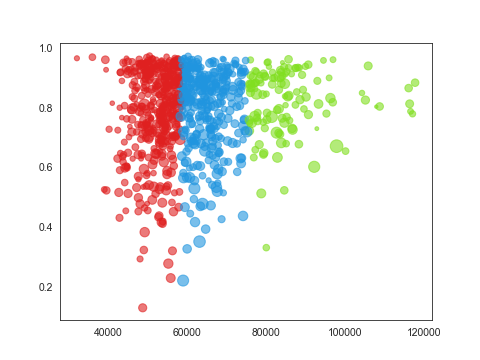

In [93]:
%matplotlib notebook

df["Population Scaled"]=(df["Total Population"]-df["Total Population"].min())/(df["Total Population"].max()-df["Total Population"].min())*150

df=df[df["% White"] >.1]

from sklearn.cluster import KMeans
import numpy as np
# k means
kmeans = KMeans(n_clusters=3, random_state=0)
df['cluster'] = kmeans.fit_predict(df[['Median HH Income', '% White']])
# get centroids
centroids = kmeans.cluster_centers_
cen_x = [i[0] for i in centroids] 
cen_y = [i[1] for i in centroids]
## add to df
df['cen_x'] = df.cluster.map({0:cen_x[0], 1:cen_x[1], 2:cen_x[2]})
df['cen_y'] = df.cluster.map({0:cen_y[0], 1:cen_y[1], 2:cen_y[2]})
# define and map colors
colors = ['#DF2020', '#81DF20', '#2095DF']



df['c'] = df.cluster.map({0:colors[0], 1:colors[1], 2:colors[2]})

plt.scatter(df["Median HH Income"], df["% White"],c=df.c, s=df["Population Scaled"], alpha = 0.6)


<IPython.core.display.Javascript object>


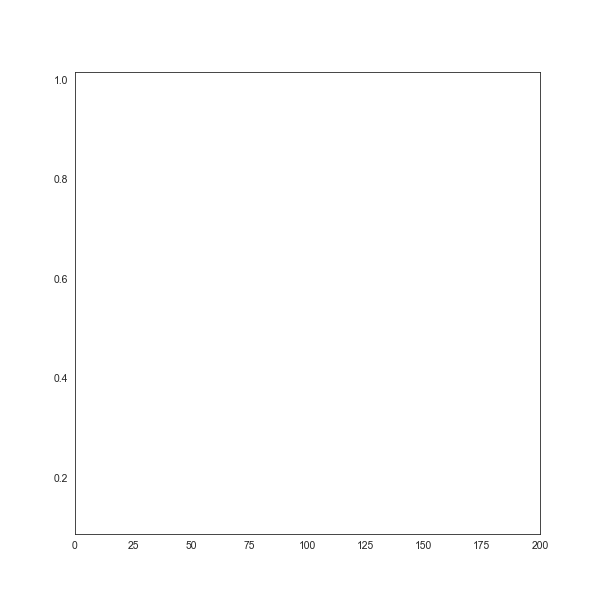

In [97]:
from scipy.spatial import ConvexHull
import numpy as np
fig, ax = plt.subplots(1, figsize=(8,8))
# plot data
plt.scatter(df["Median HH Income"], df["% White"],c=df.c,alpha = 0.6)
colors = ['#DF2020', '#81DF20', '#2095DF']
# plot centers
plt.scatter(cen_x, cen_y, marker='^', c=colors, s=70)
# draw enclosure
for i in df.cluster.unique():
    points = df[df.cluster == i][['Median HH Income', '% White']].values
    # get convex hull
    hull = ConvexHull(points)
    # get x and y coordinates
    # repeat last point to close the polygon
    x_hull = np.append(points[hull.vertices,0],
                       points[hull.vertices,0][0])
    y_hull = np.append(points[hull.vertices,1],
                       points[hull.vertices,1][0])
    # plot shape
    plt.fill(x_hull, y_hull, alpha=0.3, c=colors[i])
    
plt.xlim(0,200)

plt.show()